In [67]:
#criei o repositório para guardar as anotações do estudos de modelos (principalmente de regressão

#Regressão Polinomial
#criação de dados quadráticos não lineares com ruído

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

m = 100 # instâncias de treinamento
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

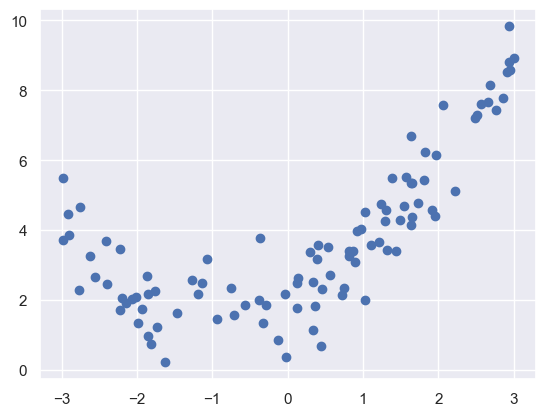

In [68]:
plt.scatter(X, y)
plt.show()

In [69]:
# Como boas práticas, é sempre necessário separar os conjuntos entre treino e teste.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [70]:
#para ajustar aos dados, usamos a classe PolynomialFeatures do SKLearn para transformar dados de treino, adicionando o quadrado de cada característica no conjunto de treinamento como uma nova característica

from sklearn.preprocessing import PolynomialFeatures
# include_bias=False: Evita adicionar uma coluna extra de 1s (que representa o viés/x^0).
# isso é feito porque a maioria dos modelos do SKLearn (como LinearRegression) já
# calcula o intercepto automaticamente, evitando assim duplicidade no termo de viés.
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X[0]

array([1.29515034])

In [71]:
X_train_poly[0]

array([1.31980121, 1.74187525])

In [72]:
# X_train_poly tem a característica original de X mais o quadrado dessa característica, dando para ajustar os dados no LinearRegression

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

lin_reg.intercept_, lin_reg.coef_

(array([1.94340297]), array([[0.86690422, 0.50940985]]))

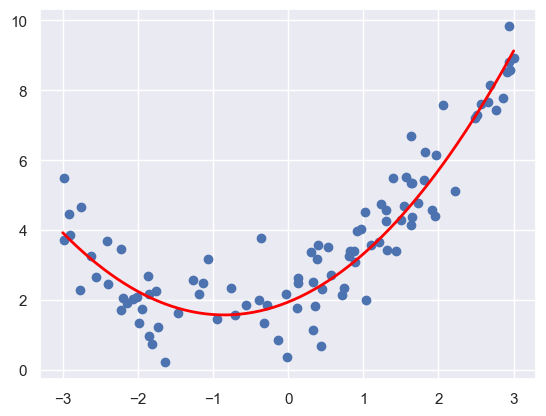

In [73]:
# em uma regressão polinomial, o modelo consegue encontrar relações entre várias características, coisa que a regressão linear não consegue. Isso por conta do PolynomialFeatures(degree=d)

#PolynomialFeatures(degree=3) não adiciona somente as características a^2, a^3, b^2, b^3, mas também as combinações de ab, a^2b, ab^2


X_new = np.linspace(-3, 3, 200).reshape(-1, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.scatter(X, y)
plt.plot(X_new, y_new, color='red', linewidth=2)
plt.show()

In [74]:
#antes de plotar as curvas de aprendizado, o livro fala sobre utilizar a validação cruzada para verificar se o modelo está se sobre ou sub-ajustando
#como já dividi os conjuntos de treino e teste, e transformei o conjunto de testes, irei aplicar a cross-validation no conjunto de treino transformado.

from sklearn.model_selection import cross_val_score
scores_test = cross_val_score(lin_reg, X_train_poly, y_train, cv=10, scoring='neg_mean_squared_error')

In [75]:
#convertemos para RMSE para ficar na mesma escala de y
lin_rmse_scores = np.sqrt(-scores_test)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

from sklearn.metrics import mean_squared_error
y_train_pred = lin_reg.predict(X_train_poly)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE TRAIN:", rmse_train)

Scores: [0.59261237 0.83834369 0.93195562 0.72435586 0.71989825 0.79876075
 0.45303629 0.99470192 0.63126221 1.28973891]
Mean: 0.7974665859716499
Standard deviation: 0.22373581048777175
RMSE TRAIN: 0.7963813086311166


In [76]:
from sklearn.metrics import mean_squared_error
y_train_pred = lin_reg.predict(X_train_poly)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_train

np.float64(0.7963813086311166)

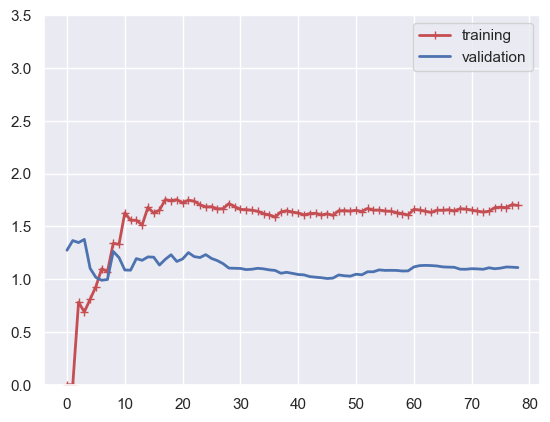

In [77]:
#curvas de aprendizado
#além da cross validation, podemos utilizar as curvas de aprendizado para saber se o modelo está tendo over ou underfitting. Elas são gráfios de desempenho do modelo no conjunto de treinamento e validação.

#Estamos criando as curvas de aprendizado de uma regressão linear simples

def plot_learning_curves(model,X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
    train_errors, val_errors = [], []

    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val_pred, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label='training')
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label='validation')
    plt.ylim(0, 3.5)
    plt.legend()
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

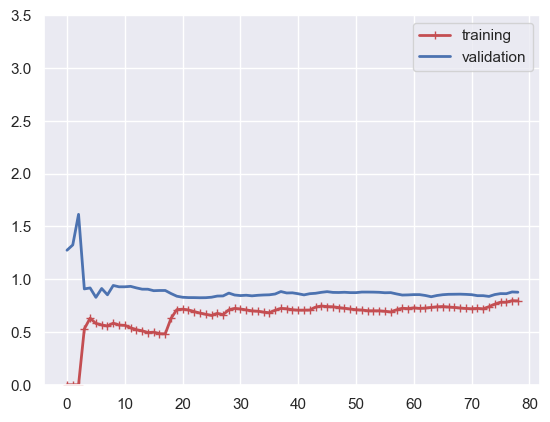

In [78]:
# aqui definimos os modelos para a função de plotar as curvas de aprendizado, onde podemos ver que a regressão polinomial de 2º grau se adequa de melhor forma aos dados. O erro se tornou mais baixo que a regressão linear e as curvas de erro ficaram próximas, não significando underfitting.

from sklearn.pipeline import Pipeline

poly_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('lin_reg', LinearRegression())
])

plot_learning_curves(poly_regression, X, y)

In [79]:
# Modelos lineares regularizados → uma boa forma de reduzir overfitting, restringindo o modelo nos seus graus de liberdade

#Regressão de ridge → versão regularizada da regressão linear
#o termo de regularização é adicionado à função de custo, junto à isso é fundamental escalonar os dados antes de realizar a regressão.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_poly)

# podemos fazer a regressão pela fórmula fechada (caderno) ou pelo gradiente descendente
from sklearn.linear_model import Ridge
ridge_regression = Ridge(alpha=1, solver='cholesky') #estamos utilizando a técnica de fatoração de matriz de André-Louis Cholesky
ridge_regression.fit(X_scaled, y_train)

x_input_poly = poly_features.transform([[1.5]])
x_input_scaled = scaler.transform(x_input_poly)

pred_scaled = ridge_regression.predict(x_input_scaled)

print(pred_scaled)


[4.38368461]


In [80]:
#e com o SGD estocástico
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty='l2') # define o tipo de termo de regularização. indica que quero que o SGD acrescente um termo de regularização à função de custo
sgd_reg.fit(X_scaled, y_train.ravel()) # exige que o vetor alvo y seja 1D, isso converte (n,1) em (n,)
pred_scaled_sgd = sgd_reg.predict(x_input_scaled)

print(pred_scaled_sgd)

[4.34033578]


In [81]:
print("Ridge", pred_scaled)
print("SGD", pred_scaled_sgd)

Ridge [4.38368461]
SGD [4.34033578]


In [82]:
#Regressão de Lasso

from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=.1)
lasso_reg.fit(X_scaled, y_train)
pred_scaled_lasso = lasso_reg.predict(x_input_scaled)

print("Ridge", pred_scaled)
print("SGD", pred_scaled_sgd)
print("Lasso", pred_scaled_lasso)

Ridge [4.38368461]
SGD [4.34033578]
Lasso [4.35891468]


In [83]:
lasso_reg = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1, max_iter=10000, tol=0.001)),
])

C:\Users\felipetp\PycharmProjects\handsOnML-housing\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


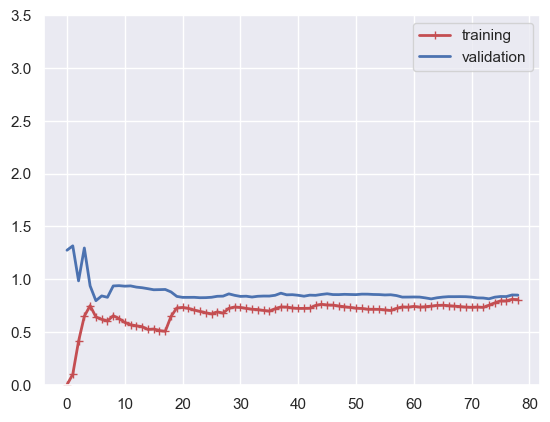

In [84]:
def plot_learning_curves_scaled(model,X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
    train_errors, val_errors = [], []

    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val_pred, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label='training')
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label='validation')
    plt.ylim(0, 3.5)
    plt.legend()

plot_learning_curves_scaled(lasso_reg, X, y)

In [85]:
from sklearn.metrics import r2_score, mean_absolute_error
scores_test = cross_val_score(lasso_reg, X,y, cv=10, scoring='neg_mean_squared_error')
lasso_rmse_scores = np.sqrt(-scores_test)

display_scores(lasso_rmse_scores)

lasso_reg.fit(X_train, y_train)

y_train_pred = lasso_reg.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print("RMSE TRAIN:", rmse_train)
print('R² train score', r2_score(y_train, y_train_pred))
print('MAE train score', mean_absolute_error(y_train, y_train_pred))

Scores: [0.88392251 0.97275006 0.7392273  1.16203192 0.87531523 0.66881566
 1.11492506 0.53153978 0.77069572 0.53898172]
Mean: 0.8258204966489281
Standard deviation: 0.20690546267040852
RMSE TRAIN: 0.8083095015909958
R² train score 0.8805820383624456
MAE train score 0.6294605560526001


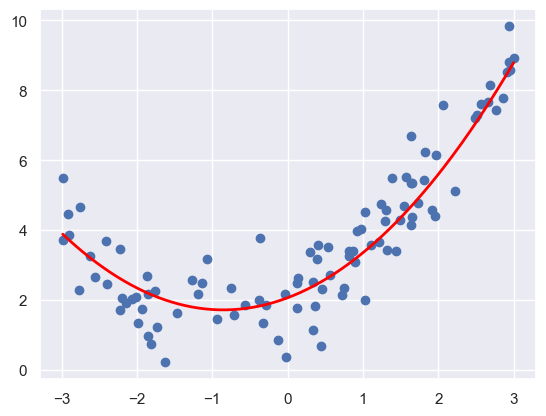

In [86]:
X_new = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
y_new = lasso_reg.predict(X_new)

plt.scatter(X, y)
plt.plot(X_new, y_new, color='red', linewidth=2)
plt.show()

In [92]:
# Elastic net - meio termo entre Lasso e Ridge, onde l1_ratio = 0 -> Ridge e l1_ratio = 1 -> Lasso
from sklearn.linear_model import ElasticNet

elastic_net = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('elastic_net', ElasticNet(alpha=0.1, l1_ratio=0.5))
])

C:\Users\felipetp\PycharmProjects\handsOnML-housing\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


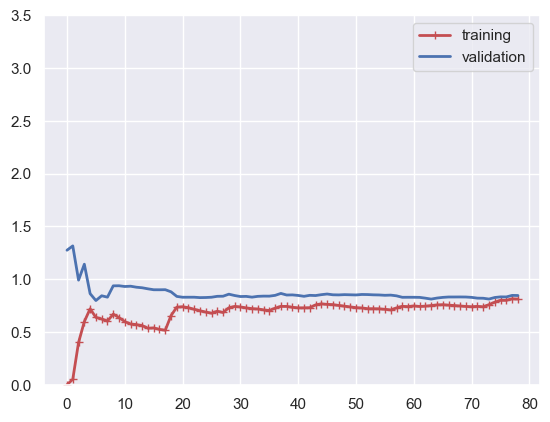

In [93]:
plot_learning_curves_scaled(elastic_net, X, y)

In [94]:
scores_test = cross_val_score(elastic_net, X,y, cv=10, scoring='neg_mean_squared_error')
elasticN_rmse_scores = np.sqrt(-scores_test)

display_scores(elasticN_rmse_scores)

elastic_net.fit(X_train, y_train)

y_train_pred = elastic_net.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print("RMSE TRAIN:", rmse_train)
print('R² train score', r2_score(y_train, y_train_pred))
print('MAE train score', mean_absolute_error(y_train, y_train_pred))

Scores: [0.87967568 0.98220408 0.74221626 1.15901839 0.88215244 0.66388368
 1.13149    0.53535654 0.77202929 0.54105394]
Mean: 0.8289080295261279
Standard deviation: 0.20891549678484717
RMSE TRAIN: 0.8135897309474729
R² train score 0.8790167623072604
MAE train score 0.6351878420092268


,Modelo,RMSE Treino,RMSE Teste,MAE Teste,R² Teste,RMSE CV (10-fold)
0,Ridge,0.796806,0.864676,0.720875,0.532123,0.828527
1,Lasso,0.808310,0.844735,0.702222,0.553453,0.851346
2,Elastic Net,0.813590,0.841408,0.700509,0.556964,0.854830


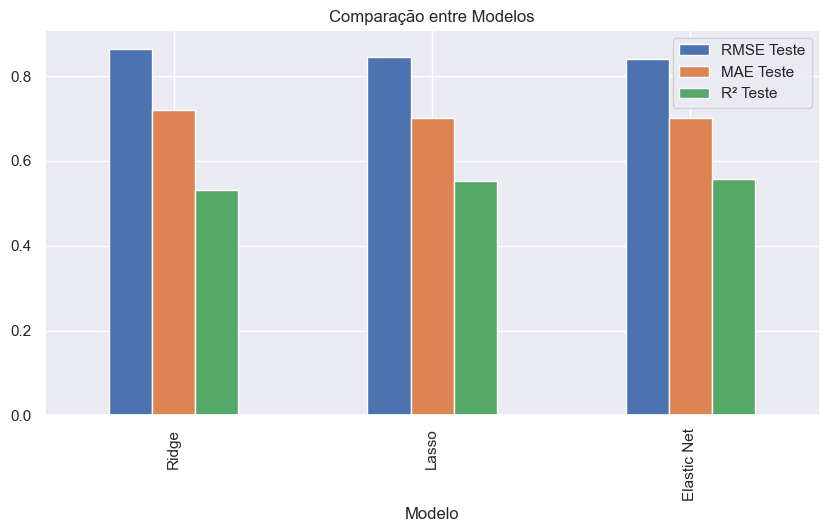

In [100]:
#Comparação entre os modelos a partir
import pandas as pd
modelos = {
    "Ridge": Ridge(alpha=1, solver='cholesky'),
    "Lasso": Pipeline([
        ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=0.1, max_iter=10000, tol=0.001)),
    ]),
    "Elastic Net": Pipeline([
        ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('elastic_net', ElasticNet(alpha=0.1, l1_ratio=0.5)),
    ])
}

resultados = []

for nome, modelo in modelos.items():

    if nome == "Ridge":
        modelo.fit(X_scaled, y_train)

        y_pred_train = modelo.predict(X_scaled)
        y_pred_test = modelo.predict(scaler.transform(poly_features.transform(X_test)))

        # cross-validation
        scores = cross_val_score(modelo, X_scaled, y_train, cv=10, scoring='neg_mean_squared_error')
        rmse_cv = np.sqrt(-scores.mean())

    else:
        modelo.fit(X_train, y_train)

        y_pred_train = modelo.predict(X_train)
        y_pred_test = modelo.predict(X_test)

        scores = cross_val_score(modelo, X, y, cv=10, scoring='neg_mean_squared_error')
        rmse_cv = np.sqrt(-scores.mean())

    resultados.append({
        "Modelo": nome,
        "RMSE Treino": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "RMSE Teste": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "MAE Teste": mean_absolute_error(y_test, y_pred_test),
        "R² Teste": r2_score(y_test, y_pred_test),
        "RMSE CV (10-fold)": rmse_cv
    })

df_resultados = pd.DataFrame(resultados)
display(df_resultados)

df_resultados.set_index("Modelo")[["RMSE Teste", "MAE Teste", "R² Teste"]].plot(
    kind="bar", figsize=(10, 5), title="Comparação entre Modelos"
)
plt.show()


In [101]:
#Regressão Logística -> utilizada para estimar probabilidades de uma instância pertencer à uma classe específica.
# Aqui iremos utilizar a base de dados iris

from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [105]:
#definimos X como a largura da especie que queremos (Iris Virginica), e y como o target == 2
X_iris = iris['data'][:, 3:]
y_iris = (iris['target'] == 2).astype(int)

In [106]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_iris, y_iris)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


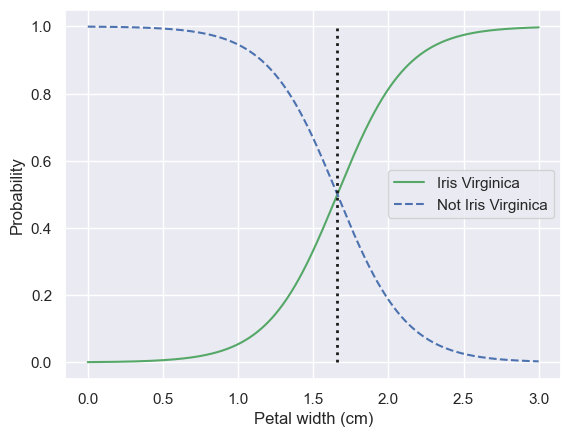

In [114]:
w = log_reg.coef_[0][0]
b = log_reg.intercept_[0]
decision_boundary = -b / w

X_new_iris = np.linspace(0, 3, 1000).reshape(-1,1)
y_proba_iris = log_reg.predict_proba(X_new_iris)
plt.plot(X_new_iris, y_proba_iris[:, 1], "g-", label='Iris Virginica')
plt.plot(X_new_iris, y_proba_iris[:, 0], "b--", label='Not Iris Virginica')
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc='best')
plt.plot([decision_boundary, decision_boundary], [0,1], "k:", linewidth=2)